In [1]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15101 MiB


In [2]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/9db565e15e8e35f1ebb48e1409b8ddb129f6f1e9/examples/dreambooth/train_dreambooth.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate>=0.20.3 transformers==4.28.0 ftfy bitsandbytes gradio huggingface_hub

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

In [4]:
#@title Install xformers precompiled wheel

# Install using pip - RECOMMENDED
!pip install -U xformers

# %pip install --no-deps -q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl
# These were compiled on Tesla T4, should also work on P100, thanks to https://github.com/metrolobo

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

In [5]:
#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown Path for images of the concept for training.
INSTANCE_DIR = "/content/data/wwhite" #@param {type:"string"}
!mkdir -p $INSTANCE_DIR

#@markdown A general name for class like dog for dog images.
CLASS_NAME = "man" #@param {type:"string"}
CLASS_DIR = f"/content/data/{CLASS_NAME}"

#@markdown A rare token name which will reference the subject.
TOKEN_NAME = "wwhite" #@param {type:"string"}

#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/wwhite" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

[*] Weights will be saved at /content/stable_diffusion_weights/wwhite


In [7]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to INSTANCE_DIR (it uploads faster)

import os
from google.colab import files
import shutil

uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

Saving ww10.jpg to ww10.jpg
Saving ww9.jpg to ww9.jpg
Saving ww8.jpg to ww8.jpg
Saving ww7.jpg to ww7.jpg
Saving ww6.jpg to ww6.jpg
Saving ww4.jpg to ww4.jpg
Saving ww3.jpg to ww3.jpg
Saving ww2.jpg to ww2.jpg


In [9]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path={MODEL_NAME} \
  --instance_data_dir={INSTANCE_DIR} \
  --class_data_dir={CLASS_DIR} \
  --output_dir={OUTPUT_DIR} \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of wwhite man" \
  --class_prompt="photo of a man" \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_checkpointing \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=1000

2023-08-03 21:05:21.658378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 21:05:23.046718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--num_cpu_threads_per_process` was set to `1` to improve out-of-box performance
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-08-03 21:05:28.193571: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Fetching 16 files:   0% 

In [10]:
#@title Convert weights to ckpt to use in web UIs like AUTOMATIC1111
#@markdown Download script
!wget -q https://github.com/ShivamShrirao/diffusers/raw/9db565e15e8e35f1ebb48e1409b8ddb129f6f1e9/scripts/convert_diffusers_to_original_stable_diffusion.py

In [11]:
#@markdown Run conversion.
ckpt_path = OUTPUT_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB), might loose some quality.
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/stable_diffusion_weights/wwhite/model.ckpt


In [12]:
#@title Inference
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from IPython.display import display

model_path = OUTPUT_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
g_cuda = None

In [13]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


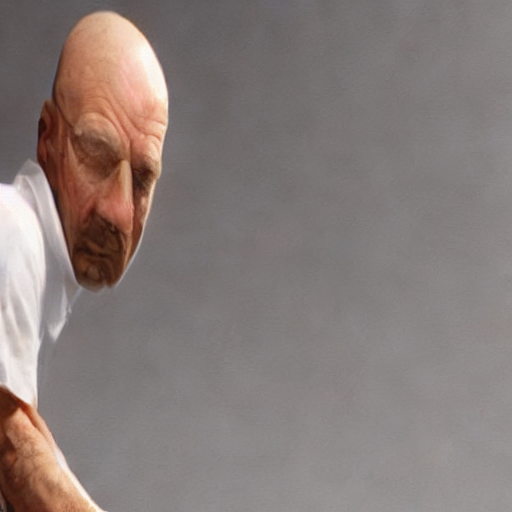

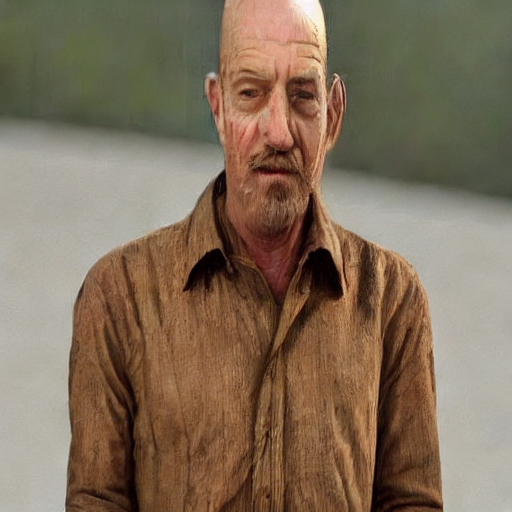

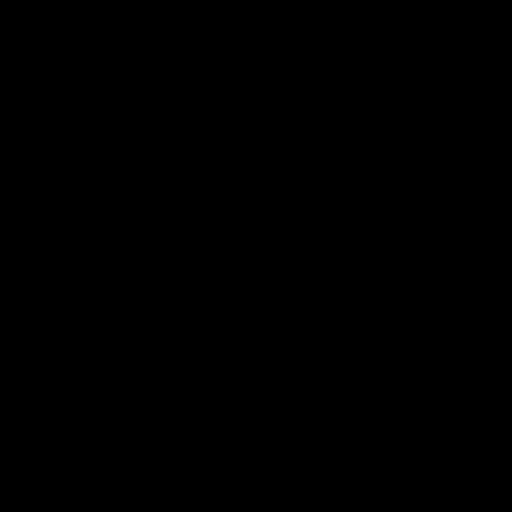

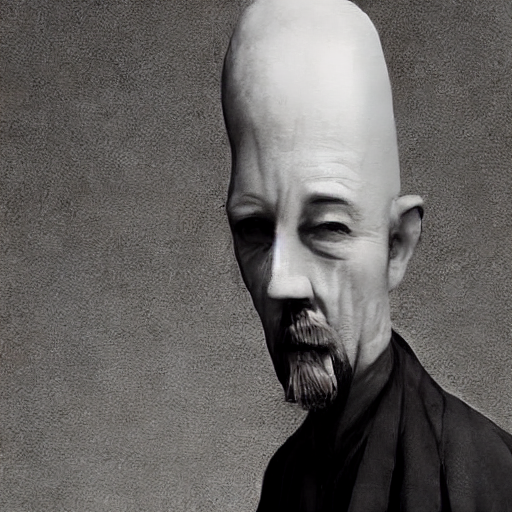

In [17]:

#@title Run for generating images.

prompt = "wwhite miser bald man, counting money" #@param {type:"string"}
negative_prompt = "" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [19]:
#@title Run Gradio UI for generating images
import gradio as gr

def inference(prompt, negative_prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
                prompt, height=int(height), width=int(width),
                negative_prompt=negative_prompt,
                num_images_per_prompt=int(num_samples),
                num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
                generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of sks guy, digital painting")
            negative_prompt = gr.Textbox(label="Negative Prompt", value="")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, negative_prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Keyboard interruption in main thread... closing server.
